## Separating PDF into Pages (texts and images) and merge them into Markdown

If you want begin with a more simple example [pdf2images.ipynb]("./pdf2images.ipynb"), and then [pdf2markdown.ipynb]("./pdf2markdown.ipynb")

In this example, we are going to build a markdown separating each page from pdf in text (ocr) and image, and then merge them into markdown.

## pdf to markdowns

* Define your basic Documents Types

In [1]:
# Install pdf2image for this example
# !pip install pdf2image

In [3]:
from document_transformer import Document, DocumentTransformer
from typing import List
from pathlib import Path
import pdf2image

class PDFDocument(Document):
    """Custom class to PDF Documents"""

class ImageDocument(Document):
    """Custom class to Image Documents"""
    def saver(self, path):
        self.data.save(path)
        return self

class TextDocument(Document):
    def saver(self, path):
        with open(path, 'w') as file:
            file.write(self.data)
        return self

* If you want to separate each pdf page in (image, text) pair, you need define `PageContent` to mantain clarity
* Consequently, is defined `PDF2Pages` transformer, which takes pdf and create each custom page.
* Observe that is created dummy text function, it takes pdf and create all texts for page, similar to `PyMuPDF` works!

In [4]:
class ContentPage(Document):
    """Document class to store the content of a page"""
    image: ImageDocument
    text: TextDocument

In [5]:
def generate_dummy_text(pdf_path: str):
    images = pdf2image.convert_from_path(pdf_path)
    texts = [f"Text from page {i+1}" for i in range(len(images))]
    return texts

class PDF2Pages(DocumentTransformer):
    input: PDFDocument = None
    output: List[ContentPage] = []

    def transformer(self) -> List[ImageDocument]:
        """Divide en páginas el documento pdf"""
        images = pdf2image.convert_from_path(self.input.path)
        texts = generate_dummy_text(self.input.path)
        return [
            ContentPage(
                image = ImageDocument(
                    metadata={'pdf_path': Path(self.input.path).name, 'page': i+1, 'size': image.size},
                    data=image,
                ),
                text = TextDocument(
                    metadata={'pdf_path': Path(self.input.path).name, 'page': i+1},
                    data=text,
                )
            )
            for i, (image, text) in enumerate(zip(images, texts))
        ]

run it!

In [6]:
pdf_doc = PDFDocument(path="document.pdf")
pages = PDF2Pages(input=pdf_doc).run()

for page in pages:
    page.image.save(path=f'images/pag_{page.image.metadata["page"]}.jpg')
    page.text.save(path=f'texts/pag_{page.text.metadata["page"]}.txt')

Observe that pdf_doc has 3 childrens (each page)

In [7]:
print("pdf_doc.id:\t\t", pdf_doc.id)
print("pdf_doc.childrens:\t", pdf_doc.childrens)
print("pages[0].id:\t\t", pages[0].id)

pdf_doc.id:		 3ba24b6f-7df9-4bec-8c5c-e9166a7c68cf
pdf_doc.childrens:	 {'ea4775df-e5fa-4e64-873c-08cfabb22497', '453f5ab3-e54c-4004-929b-9ac44a5c543b', '777395b3-43df-493d-bc02-8afd650bbe50'}
pages[0].id:		 453f5ab3-e54c-4004-929b-9ac44a5c543b


And each page contains respective text and image

In [8]:
print("pages[0].childrens:\t", pages[0].childrens)
print("pages[0].image.id:\t", pages[0].image.id)
print("pages[0].text.id:\t", pages[0].text.id)
print("pages[0].image.parents:\t", pages[0].image.parents)
print("pages[0].text.parents:\t", pages[0].text.parents)

pages[0].childrens:	 {'8cee1e31-40c0-4397-9527-e05959230e00', 'ded81605-05a2-4fc7-a6be-2adf166dd5d0'}
pages[0].image.id:	 8cee1e31-40c0-4397-9527-e05959230e00
pages[0].text.id:	 ded81605-05a2-4fc7-a6be-2adf166dd5d0
pages[0].image.parents:	 {'453f5ab3-e54c-4004-929b-9ac44a5c543b'}
pages[0].text.parents:	 {'453f5ab3-e54c-4004-929b-9ac44a5c543b'}


* If you prefier, you can define a `Pipeline`.
* It automatically traces relactions for all documents!!

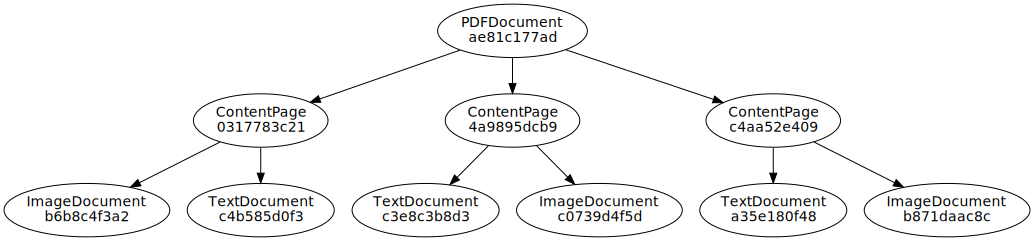

In [9]:
from document_transformer import Pipeline
from document_transformer.utils import plot_graph

pdf_doc = PDFDocument(path="document.pdf")
pipeline = Pipeline(transformers=[
    PDF2Pages(to={
        'ImageDocument': 'images/pag_{metadata[page]}.jpg',
        'TextDocument': 'texts/pag_{metadata[page]}.txt',
    })
])
pages = pipeline.run(input=pdf_doc)
plot_graph(pipeline.get_traces())

## Combine markdowns

Now, we are going to merge the markdowns. For that we need to increase the skills of `MarkdownDocument`. Let me define the `appender` method.

In [11]:
class MarkdownDocument(Document):
    data: str = ''
    def saver(self, path):
        with open(path, 'w') as file:
            file.write(self.data)
        return self

    def appender(self, other):
        """Append other markdown document content to this one"""
        self.data += other.data + '\n'
        return self


That is all, now we can to append each markdown document to another

Alternatively, you can always create a `DocumentTransformer` class to handle this task


In [12]:
class Page2Markdown(DocumentTransformer):
    input: ContentPage = None
    output: MarkdownDocument = None

    def transformer(self):
        page = self.input.image.metadata['page']
        return MarkdownDocument(
            data=(
                f"## Page {page}\n\n "
                f"[image](images/pag_{page}.jpg)\n\n "
                f"{self.input.text.data}"
            ),
            metadata={'page': page}
        )
    
class CombineMarkdowns(DocumentTransformer):
    input: List[MarkdownDocument] = []
    output: MarkdownDocument = None

    def transformer(self):
        return MarkdownDocument().extend(self.input)


Which brings a reward! Now you can extend your Pipeline

[MarkdownDocument(id='21a89868-b97f-424e-99c0-d535707ac7b7', path='markdowns/pag_1.txt', data='## Page 1\n\n [image](images/pag_1.jpg)\n\n Text from page 1', metadata={'page': 1}, parents={'f298dddf-72e3-48b2-bad1-7080bdab593f'}, childrens=set()), MarkdownDocument(id='c2c6760e-1288-4ad5-868c-4276d2c3b973', path='markdowns/pag_2.txt', data='## Page 2\n\n [image](images/pag_2.jpg)\n\n Text from page 2', metadata={'page': 2}, parents={'3e42e189-d687-49d5-a41c-b11d4b03bc7d'}, childrens=set()), MarkdownDocument(id='d893d6e3-ee43-4404-93da-52c69196aab2', path='markdowns/pag_3.txt', data='## Page 3\n\n [image](images/pag_3.jpg)\n\n Text from page 3', metadata={'page': 3}, parents={'d6f5241c-6629-49c8-b254-bff91c687310'}, childrens=set())]


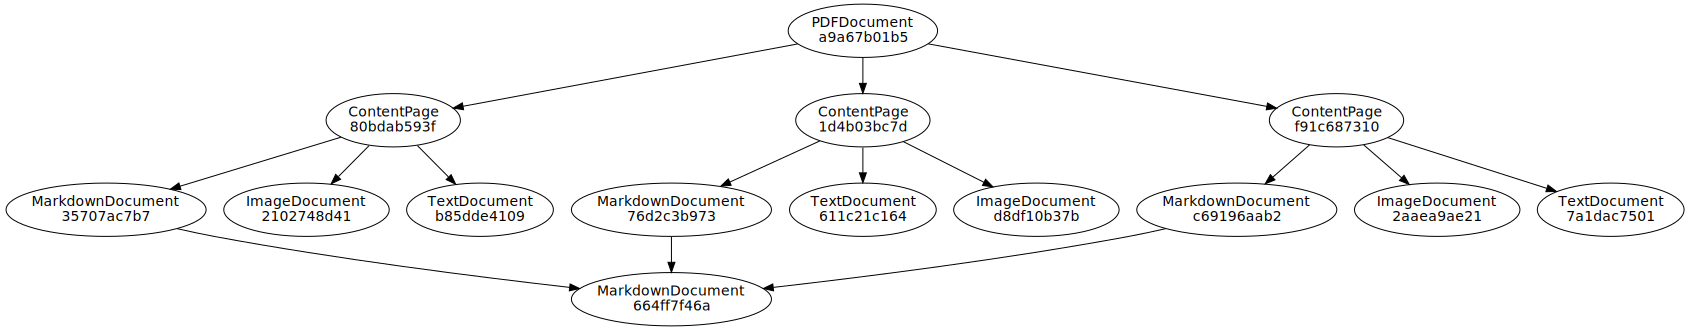

In [13]:
# Define Pipeline
pipeline = Pipeline(transformers=[
    PDF2Pages(),
    Page2Markdown(to='markdowns/pag_{metadata[page]}.txt'),
    CombineMarkdowns()
])

# Run and visualize it!
pdf_doc = PDFDocument(path="document.pdf")
markdown_doc = pipeline.run(input=pdf_doc)
plot_graph(pipeline.get_traces())

In [17]:
print(markdown_doc.data)

## Page 1

 [image](images/pag_1.jpg)

 Text from page 1
## Page 2

 [image](images/pag_2.jpg)

 Text from page 2
## Page 3

 [image](images/pag_3.jpg)

 Text from page 3



## Conclusions

As you can see, `document-transformer` enables the definition of complex document structures where Documents can contain other Documents as attributes:

```python
class ContentPage(Document):
    """Document class to store the content of a page"""
    image: ImageDocument
    text: TextDocument
```

This approach simplifies the management of hierarchical document relationships, allowing for more intuitive and flexible document handling within the pipeline.

With this structure, transformations and operations on documents become easier to implement, making it an effective tool for managing intricate document workflows.